# Integrator RNN Model

In this notebook, we train a vanilla RNN to integrate white noise. This example is useful on its own to understand how RNN training works.

In [1]:
from functools import partial
import matplotlib.pyplot as plt

import brainpy as bp
import brainpy.math as bm

## Parameters

In [2]:
dt = 0.04
num_step = int(1.0 / dt)
num_batch = 128

## Data

In [3]:
@partial(bm.jit,
         dyn_vars=bp.TensorCollector({'a': bm.random.DEFAULT}),
         static_argnames=['batch_size'])
def build_inputs_and_targets(mean=0.025, scale=0.01, batch_size=10):
  # Create the white noise input
  sample = bm.random.normal(size=(batch_size, 1, 1))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(batch_size, num_step, 1))
  noise_t = scale / dt ** 0.5 * samples
  inputs = bias + noise_t
  targets = bm.cumsum(inputs, axis=1)
  return inputs, targets

In [4]:
def train_data():
  for _ in range(100):
    yield build_inputs_and_targets(batch_size=num_batch)

## Model

In [5]:
class RNN(bp.dyn.DynamicalSystem):
  def __init__(self, num_in, num_hidden):
    super(RNN, self).__init__()
    self.rnn = bp.layers.VanillaRNN(num_in, num_hidden, train_state=True)
    self.out = bp.layers.Dense(num_hidden, 1)

  def update(self, sha, x):
    return self.out(sha, self.rnn(sha, x))

model = RNN(1, 100)

C:\Users\adadu\miniconda3\envs\brainpy\lib\site-packages\brainpy\dyn\layers\rnncells.py:419: UserWarning: Use "brainpy.layers.RNNCell" instead. "brainpy.layers.VanillaRNN" is deprecated and will be removed since 2.4.0.
  warnings.warn('Use "brainpy.layers.RNNCell" instead. '


## Training

In [6]:
# define loss function
def loss(predictions, targets, l2_reg=2e-4):
  mse = bp.losses.mean_squared_error(predictions, targets)
  l2 = l2_reg * bp.losses.l2_norm(model.train_vars().unique().dict()) ** 2
  return mse + l2


# define optimizer
lr = bp.optim.ExponentialDecay(lr=0.025, decay_steps=1, decay_rate=0.99975)
opt = bp.optim.Adam(lr=lr, eps=1e-1)


# create a trainer
trainer = bp.train.BPTT(model, loss_fun=loss, optimizer=opt)
trainer.fit(train_data,
            num_epoch=30,
            num_report=200)

Train 200 steps, use 2.0827 s, loss 0.10219073295593262
Train 400 steps, use 1.1600 s, loss 0.02992606721818447
Train 600 steps, use 1.1305 s, loss 0.020649278536438942
Train 800 steps, use 1.1202 s, loss 0.0201699398458004
Train 1000 steps, use 1.1438 s, loss 0.01982983388006687
Train 1200 steps, use 1.1005 s, loss 0.019389821216464043
Train 1400 steps, use 1.1002 s, loss 0.022438863292336464
Train 1600 steps, use 1.1616 s, loss 0.01984506845474243
Train 1800 steps, use 1.1634 s, loss 0.018056627362966537
Train 2000 steps, use 1.1306 s, loss 0.017613112926483154
Train 2200 steps, use 1.1302 s, loss 0.01725911907851696
Train 2400 steps, use 1.1092 s, loss 0.016880011186003685
Train 2600 steps, use 1.1122 s, loss 0.016549108549952507
Train 2800 steps, use 1.1237 s, loss 0.016249286010861397
Train 3000 steps, use 1.1064 s, loss 0.015962772071361542


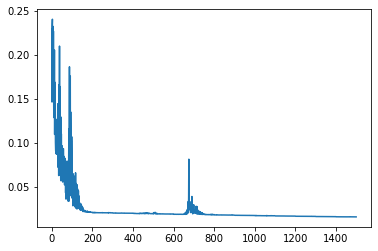

In [7]:
plt.plot(bm.as_numpy(trainer.get_hist_metric()))
plt.show()

## Testing

  0%|          | 0/25 [00:00<?, ?it/s]

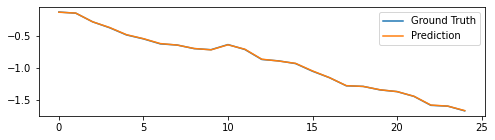

In [8]:
model.reset_state(1)
x, y = build_inputs_and_targets(batch_size=1)
predicts = trainer.predict(x)

plt.figure(figsize=(8, 2))
plt.plot(bm.as_numpy(y[0]).flatten(), label='Ground Truth')
plt.plot(bm.as_numpy(predicts[0]).flatten(), label='Prediction')
plt.legend()
plt.show()